In [1]:
#!pip install tqdm

In [8]:
# import necessary packages
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import earthpy as et
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

In [9]:
%matplotlib inline

# LA County Shapefile

In [10]:
# Graph neighbors of a region
def graph_neighbors(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)
    temp_n = df[df.region == region].neighbors.values[0].split(',')
    temp_n = [n.strip() for n in temp_n]
    for n in temp_n:
        df.plot_col = df.plot_col.mask(df['region'] == n, 2)
    ax = df.plot(column='plot_col', figsize=(10,10))
    green_patch = mpatches.Patch(color='green', label='Covering Polygon')
    yellow_patch = mpatches.Patch(color='yellow', label='Bordering Regions')
    purple_patch = mpatches.Patch(color='purple', label='Inner LA County')
    plt.legend(handles=[green_patch, yellow_patch, purple_patch])
#     ax.annotate()
#     df.apply(lambda x: ax.annotate(s=x.region, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    
# Graph region
def graph_region(df, region):
    df['plot_col'] = 0
    df.plot_col = df.plot_col.mask(df['region'] == region, 1)

    df.plot(column='plot_col', figsize=(10,10), alpha=0.5)

In [11]:
# Load the shape file from github
# !wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
# !unzip -nq la_shape -d shape

In [12]:
# la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
la_filtered = la_shapes.rename(columns={'name':'region'})
la_filtered["neighbors"] = None  # add NEIGHBORS column
la_filtered["plot_col"] = 0 # Column used to graph neighbors
la_filtered = la_filtered[['region','geometry','neighbors','plot_col']]
la_filtered.head()

,region,geometry,neighbors,plot_col
0,Acton,"POLYGON ((-118.20262 34.53899, -118.18947 34.5...",None,0
1,Adams-Normandie,"POLYGON ((-118.30901 34.03741, -118.30041 34.0...",None,0
2,Agoura Hills,"POLYGON ((-118.76193 34.16820, -118.72632 34.1...",None,0
3,Agua Dulce,"POLYGON ((-118.25468 34.55830, -118.25551 34.5...",None,0
4,Alhambra,"POLYGON ((-118.12175 34.10504, -118.11687 34.1...",None,0


## Get bordering regions

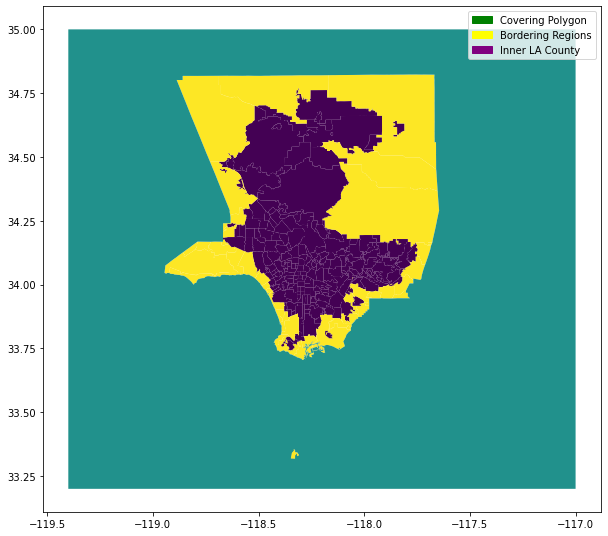

In [13]:
# Create a polygon that covers the entire la county region
cover = gpd.GeoSeries(Polygon([(-119.4,35), (-119.4,33.2), (-117,33.2), (-117,35)])).set_crs(epsg=4269)
# Remove Catalina Island since it is an island which has no neighbors
la_noisland = la_filtered[la_filtered['region']!='Unincorporated Catalina Island']
# Remove small holes within the la county unary union polygon
no_holes = MultiPolygon(Polygon(p.exterior) for p in la_noisland.geometry.unary_union)
no_holes_series = gpd.GeoSeries(no_holes).set_crs(epsg=4269)
# Subtract la county from the covering polygon
diff = gpd.GeoSeries.difference(cover, no_holes_series)
# We can find the cities that are touching 'diff' to locate border cities
# diff.plot(figsize=(5,5))
# Get neighbors of diff to obtain bordered regions
border_regions = la_filtered[~la_filtered.geometry.disjoint(diff[0])].region.tolist()
la_filtered.loc[len(la_filtered)] = ["COVER", diff[0], ", ".join(border_regions), 0]
graph_neighbors(la_filtered, 'COVER')
la_filtered = la_filtered[:-1]

## Get neighbors of each region

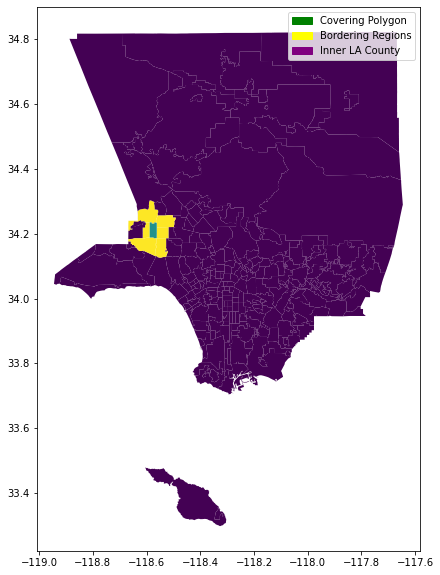

In [14]:
for index, row in la_filtered.iterrows():   
    # Get neighboring cities
    neighbors = la_filtered[~la_filtered.geometry.disjoint(row.geometry)].region.tolist()
    # Remove own name from list
    if row['region'] in neighbors:
        neighbors.remove(row['region'])
    la_filtered.at[index, "neighbors"] = ", ".join(neighbors)
graph_neighbors(la_filtered, 'Winnetka')
la_filtered = la_filtered[['region','neighbors','geometry']]

## Remove bordering regions

In [15]:
la_inner = la_filtered[~la_filtered['region'].isin(border_regions)]
la_inner.shape

(227, 3)

## Smooth/process COVID data

In [16]:
!wget --directory-prefix=../data/covid -Nq https://raw.githubusercontent.com/ANRGUSC/lacounty_covid19_data/master/data/Covid-19.csv
covid_filename = '../data/covid/Covid-19.csv'

covid_df = pd.read_csv(covid_filename)
covid_df = covid_df.rename(columns={'Region':'region', 'Number of cases':'cases'})
covid_df.head()

,Time Stamp,region,Latitude,Longitude,cases
0,03-16-2020,Alhambra,34.093042,-118.127060,2
1,03-16-2020,Arcadia,34.136208,-118.040150,1
2,03-16-2020,Beverly Hills,34.069650,-118.396306,1
3,03-16-2020,Boyle Heights,34.043689,-118.209768,5
4,03-16-2020,Carson,33.832204,-118.251755,1


In [17]:
# Set COVID cases to not be less than previously recorded - it should be a non-decreasing function
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    if prev_cases > row['cases']:
      covid_df.loc[idx, 'cases'] =  prev_cases
    else:
      prev_cases = row['cases']

In [18]:
for region in covid_df["region"].unique():
  df = covid_df[covid_df['region'] == region]
  prev_cases = 0
  for idx, row in df.iterrows():
    covid_df.loc[idx, 'active_cases'] =  row['cases'] - prev_cases
    prev_cases = row['cases']
covid_df[covid_df['region'] == 'Alhambra']

,Time Stamp,region,Latitude,Longitude,cases,active_cases
0,03-16-2020,Alhambra,34.093042,-118.12706,2,2.0
31,03-17-2020,Alhambra,34.093042,-118.12706,2,0.0
73,03-18-2020,Alhambra,34.093042,-118.12706,2,0.0
118,03-19-2020,Alhambra,34.093042,-118.12706,2,0.0
188,03-20-2020,Alhambra,34.093042,-118.12706,3,1.0
...,...,...,...,...,...,...
50025,10-5-2020,Alhambra,34.093042,-118.12706,1391,0.0
50264,10-6-2020,Alhambra,34.093042,-118.12706,1391,0.0
50503,10-7-2020,Alhambra,34.093042,-118.12706,1391,0.0
50742,10-8-2020,Alhambra,34.093042,-118.12706,1391,0.0


## Fix inconsistencies in region name mapping

In [19]:
la_to_covid = {
    'Downtown': ['City', 'Pico', 'Wholesale District', 'Central', 'Little Tokyo', 'Temple-Beaudry'],
    'Silver Lake': ['Silverlake'],
    'Vernon': ['West Vernon', 'Vernon Central'],
    'Baldwin Hills/Crenshaw': ['Baldwin Hills'],
    'West Hollywood': ['Park LaBrea'],
    'Mid-Wilshire': ['Park LaBrea', 'Cloverdale/Cochran'],
    'Santa Clarity': ['Canyon Country'],
    'Echo Park': ['Angelino Heights'],
    'Avocado Heights': ['Bassett'],
    'Bel-Air': ['Bel Air'],
    'Arlington Heights': ['Country Club Park'],
    'Exposition Park': ['Exposition'],
    'Chinatown': ['Figueroa Park Square'],
    'Torrance': ['Gramercy Place'],
    'Harbor City': ['Harbor Pines'],
    'Mid-City': ['Lafayette Square', 'Mid-city', 'Reynier Village', 'Victoria Park', 'Wellington Square'],
    'Azusa': ['Lakeview Terrace'],
    'East Hollywood': ['Little Armenia'],
    'Playa Vista': ['Longwood'],
    'Brentwood': ['Mandeville Canyon'],
    'Playa del Rey': ['Playa Del Rey'],
    'Porter Ranch': ['Reseda Ranch'],
    'Carthay': ['South Carthay'],
    'Los Feliz': ['Thai Town'],
    'Toluca Lake': ['Toluca Terrace'],
    'El Sereno': ['University Hills'],
    'Angeles Crest': ['Angeles National Forest'],
    'Mount Washington': ['Mt. Washington']
}

for key, value in la_to_covid.items():
    covid_df.loc[covid_df['region'].isin(value), 'region'] = key

### Set low pop covid cases to 0

In [112]:
covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.region), columns=['region'])
population_df = pd.read_csv('../data/social_explorer_processed_data.csv')[['name','Total Population:']]
population_df = population_df.rename(columns={'name':'region', 'Total Population:': 'population'})
# population_df.plot.hist(by='region', figsize=(10,10))

Histogram of pop of regions w/ covid data

<AxesSubplot:ylabel='Frequency'>

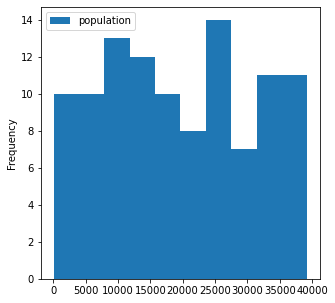

In [113]:
covid_population = population_df[population_df['region'].isin(pd.unique(covid_df.region))]
covid_population[covid_population.population <= 40000].plot.hist(by='region', figsize=(5,5), bins=10)

Histogram of pop of regions w/ missing covid data

<AxesSubplot:ylabel='Frequency'>

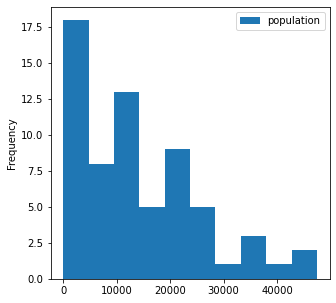

In [114]:
check_df = population_df.assign(InDf2=population_df.region.isin(covid_unique_regions.region))
miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
covid_no_data = population_df[population_df['region'].isin(miss_arr)]
covid_no_data[covid_no_data.population <= 100000].plot.hist(by='region', figsize=(5,5), bins=10)

Smaller regions have more missing data in general, but there are also outliers

Small regions w/ a lot of covid cases

In [111]:
small_pop_region = population_df[population_df['population'] <= 5000]['region'].values
pd.unique(covid_df_month[covid_df_month.region.isin(small_pop_region)].region)
covid_df_month[covid_df_month.region.isin(small_pop_region)].groupby('region').sum()

,month,cases
region,,
Angeles Crest,52,258
Avalon,52,2133
Bel-Air,52,11217
Beverlywood,52,18303
Bradbury,52,1607
Century City,52,14753
Elysian Park,52,10405
Harvard Park,52,175093
Irwindale,52,6859


Big regions w/ no covid cases

In [115]:
print(covid_no_data[covid_no_data.population >= 30000].region.values)

['Castaic Canyons' 'Central-Alameda' 'Historic South-Central' 'Long Beach'
 'Sawtelle' 'Vermont-Slauson' 'Westmont']


### Remove regions w/ missing neighbors & their neighbors

In [20]:
covid_unique_regions = pd.DataFrame(data=pd.unique(covid_df.region), columns=['region'])
check_df = la_inner.assign(InDf2=la_inner.region.isin(covid_unique_regions.region))
miss_arr = pd.unique(check_df[check_df['InDf2']==False]['region'])
miss_set = set(miss_arr)
for region in miss_arr:
    temp_n = la_inner[la_inner.region == region].neighbors.values[0].split(',')
    temp_n = set([n.strip() for n in temp_n])
    miss_set = miss_set | temp_n
miss_arr = list(miss_set)
la_inner = la_inner[~la_inner['region'].isin(miss_arr)]
la_inner.shape

(52, 3)

# Aggregate Covid Data

## Census data

In [21]:
census_data = pd.read_csv('../data/social_explorer_processed_data_only_percents.csv')
census_data.shape

(261, 168)

In [22]:
census_data.dropna().dtypes

name                                           object
% Area Total: Area (Land)                     float64
% Area Total: Area (Water)                    float64
% Total Population: Under 5 Years             float64
% Total Population: 5 to 9 Years              float64
                                               ...   
% Households10: 3-Person Household            float64
% Households10: 4-Person Household            float64
% Households10: 5-Person Household            float64
% Households10: 6-Person Household            float64
% Households10: 7-or-More Person Household    float64
Length: 168, dtype: object

In [23]:
# Get all regions that have data
census_unique_regions = pd.DataFrame(data=pd.unique(census_data.name),columns=['region'])
regions = pd.merge(covid_unique_regions, la_inner[['region']], on='region', how='inner')
regions = pd.merge(regions, census_unique_regions, on='region', how='inner')['region'].values
len(regions)

52

## Month aggregate

In [24]:
covid_df_month = covid_df[['Time Stamp', 'region', 'active_cases']]
covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_month = covid_df_month.set_index('Time Stamp')
covid_df_month = covid_df_month.groupby([pd.Grouper(freq='M'), 'region']).sum()
covid_df_month = covid_df_month.reset_index(level=['Time Stamp','region']).rename(columns={'Time Stamp': 'month'})
covid_df_month.month = covid_df_month.month.dt.month
covid_df_month

<ipython-input-24-f93e37000ff8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])


,month,region,active_cases
0,3,Acton,0.0
1,3,Adams-Normandie,5.0
2,3,Agoura Hills,11.0
3,3,Alhambra,13.0
4,3,Alsace,0.0
...,...,...,...
1725,10,Willowbrook,0.0
1726,10,Wilmington,115.0
1727,10,Wilshire Center,90.0
1728,10,Winnetka,186.0


In [127]:
covid_df[covid_df['region'] == 'East Los Angeles']

,Time Stamp,region,Latitude,Longitude,cases
134,03-19-2020,East Los Angeles,34.023902,-118.172016,1
207,03-20-2020,East Los Angeles,34.023902,-118.172016,1
290,03-21-2020,East Los Angeles,34.023902,-118.172016,1
387,03-22-2020,East Los Angeles,34.023902,-118.172016,2
491,03-23-2020,East Los Angeles,34.023902,-118.172016,2
...,...,...,...,...,...
50081,10-5-2020,East Los Angeles,34.023902,-118.172016,6458
50320,10-6-2020,East Los Angeles,34.023902,-118.172016,6476
50559,10-7-2020,East Los Angeles,34.023902,-118.172016,6515
50798,10-8-2020,East Los Angeles,34.023902,-118.172016,6541


### Data w/o census

In [28]:
month_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_month.month)
# List of month case sums
covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        # Get cases for current region
        region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['active_cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases, fill missing neighbor data with avg of other neighbors
        neighbors = (la_inner[la_inner['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == neighbor)]['active_cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['active_cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get cases for next time_frame
        next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['active_cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(month_data_no_census.shape) == 1:
            month_data_no_census = np.array([row_data])
        else:
            month_data_no_census = np.append(month_data_no_census, [row_data], axis=0)
month_data_no_census

array([[3.0000e+00, 1.3000e+01, 2.2000e+01, 2.4500e+03, 3.1000e+01],
       [3.0000e+00, 1.1000e+01, 9.3000e+01, 2.4500e+03, 1.9000e+02],
       [3.0000e+00, 1.2000e+01, 9.2000e+01, 2.4500e+03, 1.4600e+02],
       ...,
       [8.0000e+00, 1.2000e+01, 6.2800e+02, 5.0431e+04, 9.0000e+00],
       [8.0000e+00, 6.1000e+01, 6.1000e+01, 5.0431e+04, 3.2000e+01],
       [8.0000e+00, 7.0000e+01, 1.3980e+03, 5.0431e+04, 6.3000e+01]])

In [29]:
month_data_no_census.shape

(312, 5)

In [33]:
month_data_with_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_month.month)
# List of month case sums
covid_month_gp = covid_df_month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last month since data for last month is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        # Get cases for current region
        region_cases = covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == region)]['active_cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases, fill missing neighbor data with avg of other neighbors
        neighbors = (la_inner[la_inner['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_month.loc[(covid_df_month.month == time_frame) & (covid_df_month.region == neighbor)]['active_cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_month_gp[covid_month_gp['month'] == time_frame]['active_cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get census data
        census_row = census_data[census_data['name']==region].values[0][1:]/100
        row_data = np.append(row_data, census_row)
        
        # Get cases for next time_frame
        next_cases = covid_df_month.loc[(covid_df_month.month == time_frames[i+1]) & (covid_df_month.region == region)]['active_cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(month_data_with_census.shape) == 1:
            month_data_with_census = np.array([row_data])
        else:
            month_data_with_census = np.append(month_data_with_census, [row_data], axis=0)
month_data_with_census = month_data_with_census.astype(float)
month_data_with_census

array([[3.00000000e+00, 1.30000000e+01, 2.20000000e+01, ...,
        2.21225405e-02, 1.25055221e-02, 3.10000000e+01],
       [3.00000000e+00, 1.10000000e+01, 9.30000000e+01, ...,
        6.49930379e-02, 6.79416824e-02, 1.90000000e+02],
       [3.00000000e+00, 1.20000000e+01, 9.20000000e+01, ...,
        3.58642972e-02, 1.95245788e-02, 1.46000000e+02],
       ...,
       [8.00000000e+00, 1.20000000e+01, 6.28000000e+02, ...,
        2.20381110e-02, 1.82270091e-03, 9.00000000e+00],
       [8.00000000e+00, 6.10000000e+01, 6.10000000e+01, ...,
        3.07034590e-02, 1.12708900e-02, 3.20000000e+01],
       [8.00000000e+00, 7.00000000e+01, 1.39800000e+03, ...,
        8.71640552e-03, 0.00000000e+00, 6.30000000e+01]])

In [34]:
month_data_with_census[:,~np.isnan(month_data_with_census).any(axis=0)].shape

(312, 172)

In [35]:
month_data_with_census.dtype

dtype('float64')

In [32]:
np.savetxt("../data/covid/covid_month_with_census_filtered.csv", month_data_with_census, delimiter=",")

In [37]:
# np.save('../data/covid/covid_month_no_census_filtered', month_data_no_census)
np.save('../data/covid/covid_month_with_census_filtered', month_data_with_census)

### Week Aggregate

In [21]:
covid_df_week = covid_df[['Time Stamp', 'Region', 'Number of cases']]
covid_df_week['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_week = covid_df_week.set_index('Time Stamp')
covid_df_week = covid_df_week.groupby([pd.Grouper(freq='W'), 'Region']).sum()
covid_df_week = covid_df_week.reset_index(level=['Time Stamp','Region']).rename(columns={'Time Stamp': 'week', 'Region':'region', 'Number of cases':'cases'})
covid_df_week.week = covid_df_week.week.dt.week
covid_df_week

<ipython-input-21-45b2c6178f57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_week['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
<ipython-input-21-45b2c6178f57>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  covid_df_week.week = covid_df_week.week.dt.week


,week,region,cases
0,12,Alhambra,15
1,12,Altadena,9
2,12,Arcadia,12
3,12,Athens,1
4,12,Baldwin Hills,9
...,...,...,...
7051,41,Willowbrook,1728
7052,41,Wilmington,12840
7053,41,Wilshire Center,7991
7054,41,Winnetka,9229


In [22]:
week_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_week.week)
# List of month case sums
covid_week_gp = covid_df_week.groupby('week').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_week.loc[(covid_df_week.week == time_frame) & (covid_df_week.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_month.loc[(covid_df_week.week == time_frame) & (covid_df_week.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors) ## All neighbor data missing, fill with region itself
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_week_gp[covid_week_gp['week'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get cases for next time_frame
        next_cases = covid_df_week.loc[(covid_df_week.week == time_frames[i+1]) & (covid_df_week.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])

        # Add data to numpy arr
        if len(week_data_no_census.shape) == 1:
            week_data_no_census = np.array([row_data])
        else:
            week_data_no_census = np.append(week_data_no_census, [row_data], axis=0)
week_data_no_census

array([[1.20000000e+01, 1.50000000e+01, 0.00000000e+00, 1.29500000e+03,
        5.10000000e+01],
       [1.20000000e+01, 1.20000000e+01, 1.20000000e+02, 1.29500000e+03,
        4.00000000e+01],
       [1.20000000e+01, 3.00000000e+01, 1.46933333e+03, 1.29500000e+03,
        1.18000000e+02],
       ...,
       [3.90000000e+01, 8.07600000e+03, 5.65320000e+04, 1.72815000e+06,
        8.29000000e+03],
       [3.90000000e+01, 1.94400000e+03, 1.16640000e+04, 1.72815000e+06,
        2.00600000e+03],
       [3.90000000e+01, 1.23280000e+04, 4.93120000e+04, 1.72815000e+06,
        1.25980000e+04]])

In [23]:
week_data_no_census.shape

(5180, 5)

In [24]:
week_data_with_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_week.week)
# List of month case sums
covid_week_gp = covid_df_week.groupby('week').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_week.loc[(covid_df_week.week == time_frame) & (covid_df_week.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_month.loc[(covid_df_week.week == time_frame) & (covid_df_week.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors) ## All neighbor data missing, fill with region itself
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_week_gp[covid_week_gp['week'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get census data
        census_row = census_data[census_data['name']==region].values[0][1:]
        row_data = np.append(row_data, census_row)
        
        # Get cases for next time_frame
        next_cases = covid_df_week.loc[(covid_df_week.week == time_frames[i+1]) & (covid_df_week.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])

        # Add data to numpy arr
        if len(week_data_with_census.shape) == 1:
            week_data_with_census = np.array([row_data])
        else:
            week_data_with_census = np.append(week_data_with_census, [row_data], axis=0)
week_data_with_census

array([[12.0, 15.0, 0.0, ..., 2.212254052, 1.250552214, 51],
       [12, 12, 120, ..., 2.244841816, 2.206327373, 40],
       [12.0, 30.0, 1469.3333333333335, ..., 1.83572923,
        0.060741040999999996, 118],
       ...,
       [39, 8076, 56532, ..., 1.7230211169999998, 0.823940925, 8290],
       [39, 1944, 11664, ..., 0.7894473870000001, 0.48965724, 2006],
       [39, 12328, 49312, ..., 8.839935042, 6.587587376, 12598]],
      dtype=object)

In [25]:
week_data_with_census.shape

(5180, 172)

In [26]:
np.save('../data/covid/covid_week_no_census', week_data_no_census)
np.save('../data/covid/covid_week_with_census', week_data_with_census)

### 3-month aggregate

In [27]:
covid_df_3month = covid_df[['Time Stamp', 'Region', 'Number of cases']]
covid_df_3month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_3month = covid_df_3month.set_index('Time Stamp')
covid_df_3month = covid_df_3month.groupby([pd.Grouper(freq='3M'), 'Region']).sum()
covid_df_3month = covid_df_3month.reset_index(level=['Time Stamp','Region']).rename(columns={'Time Stamp': 'month', 'Region':'region', 'Number of cases':'cases'})
covid_df_3month.month = covid_df_3month.month.dt.month
covid_df_3month


<ipython-input-27-84e9f6ee84a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_3month['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])


,month,region,cases
0,3,Acton,0
1,3,Adams-Normandie,5
2,3,Agoura Hills,56
3,3,Alhambra,90
4,3,Alsace,0
...,...,...,...
960,12,Willowbrook,2708
961,12,Wilmington,20071
962,12,Wilshire Center,12475
963,12,Winnetka,14354


In [28]:
three_month_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_3month.month)
# List of month case sums
covid_3month_gp = covid_df_3month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_3month.loc[(covid_df_3month.month == time_frame) & (covid_df_3month.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_3month.loc[(covid_df_3month.month == time_frame) & (covid_df_3month.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_3month_gp[covid_3month_gp['month'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get cases for next time_frame
        next_cases = covid_df_3month.loc[(covid_df_3month.month == time_frames[i+1]) & (covid_df_3month.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])

        # Add data to numpy arr
        if len(three_month_data_no_census.shape) == 1:
            three_month_data_no_census = np.array([row_data])
        else:
            three_month_data_no_census = np.append(three_month_data_no_census, [row_data], axis=0)
three_month_data_no_census

array([[3.0000000e+00, 9.0000000e+01, 1.1600000e+02, 1.2407000e+04,
        1.3784000e+04],
       [3.0000000e+00, 7.1000000e+01, 5.5000000e+01, 1.2407000e+04,
        5.7270000e+03],
       [3.0000000e+00, 2.1100000e+02, 1.3584000e+03, 1.2407000e+04,
        1.1006000e+04],
       ...,
       [6.0000000e+00, 2.0067000e+04, 1.9788825e+05, 3.5824330e+06,
        8.3992000e+04],
       [6.0000000e+00, 8.4880000e+03, 5.8767600e+04, 3.5824330e+06,
        2.1248000e+04],
       [6.0000000e+00, 1.8812000e+04, 1.4009200e+05, 3.5824330e+06,
        1.2318600e+05]])

In [29]:
three_month_data_no_census.shape

(370, 5)

In [30]:
three_month_data_with_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_3month.month)
# List of month case sums
covid_3month_gp = covid_df_3month.groupby('month').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_3month.loc[(covid_df_3month.month == time_frame) & (covid_df_3month.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_3month.loc[(covid_df_3month.month == time_frame) & (covid_df_3month.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_3month_gp[covid_3month_gp['month'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get census data
        census_row = census_data[census_data['name']==region].values[0][1:]
        row_data = np.append(row_data, census_row)
        
        # Get cases for next time_frame
        next_cases = covid_df_3month.loc[(covid_df_3month.month == time_frames[i+1]) & (covid_df_3month.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])

        # Add data to numpy arr
        if len(three_month_data_with_census.shape) == 1:
            three_month_data_with_census = np.array([row_data])
        else:
            three_month_data_with_census = np.append(three_month_data_with_census, [row_data], axis=0)
three_month_data_with_census

array([[3.0, 90.0, 116.0, ..., 2.212254052, 1.250552214, 13784],
       [3.0, 71.0, 55.0, ..., 2.244841816, 2.206327373, 5727],
       [3.0, 211.0, 1358.4, ..., 1.83572923, 0.060741040999999996, 11006],
       ...,
       [6.0, 20067.0, 197888.25, ..., 1.7230211169999998, 0.823940925,
        83992],
       [6.0, 8488.0, 58767.6, ..., 0.7894473870000001, 0.48965724, 21248],
       [6.0, 18812.0, 140092.0, ..., 8.839935042, 6.587587376, 123186]],
      dtype=object)

In [31]:
three_month_data_with_census.shape

(370, 172)

In [32]:
np.save('../data/covid/covid_3month_no_census', three_month_data_no_census)
np.save('../data/covid/covid_3month_with_census', three_month_data_with_census)

### Daily aggregate

In [33]:
covid_df_day = covid_df[['Time Stamp', 'Region', 'Number of cases']]
covid_df_day['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])
covid_df_day = covid_df_day.set_index('Time Stamp')
covid_df_day = covid_df_day.groupby([pd.Grouper(freq='D'), 'Region']).sum()
covid_df_day = covid_df_day.reset_index(level=['Time Stamp','Region']).rename(columns={'Time Stamp': 'day', 'Region':'region', 'Number of cases':'cases'})
covid_df_day.day = covid_df_day.day.dt.dayofyear
covid_df_day


<ipython-input-33-cb5b261e19bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_day['Time Stamp'] = pd.to_datetime(covid_df['Time Stamp'])


,day,region,cases
0,76,Alhambra,2
1,76,Arcadia,1
2,76,Beverly Hills,1
3,76,Boyle Heights,5
4,76,Carson,1
...,...,...,...
48583,285,Willowbrook,248
48584,285,Wilmington,1851
48585,285,Wilshire Center,1152
48586,285,Winnetka,1349


In [34]:
day_data_no_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_day.day)
# List of month case sums
covid_day_gp = covid_df_day.groupby('day').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_day.loc[(covid_df_day.day == time_frame) & (covid_df_day.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_day.loc[(covid_df_day.day == time_frame) & (covid_df_day.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_day_gp[covid_day_gp['day'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get cases for next time_frame
        next_cases = covid_df_day.loc[(covid_df_day.day == time_frames[i+1]) & (covid_df_day.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(day_data_no_census.shape) == 1:
            day_data_no_census = np.array([row_data])
        else:
            day_data_no_census = np.append(day_data_no_census, [row_data], axis=0)
day_data_no_census

array([[7.60000e+01, 2.00000e+00, 1.00000e+01, 6.00000e+01, 1.00000e+00],
       [7.60000e+01, 1.00000e+00, 1.00000e+01, 6.00000e+01, 1.00000e+00],
       [7.60000e+01, 1.00000e+00, 4.00000e+01, 6.00000e+01, 1.00000e+00],
       ...,
       [2.83000e+02, 1.20900e+03, 9.67750e+03, 2.50075e+05, 1.21200e+03],
       [2.83000e+02, 2.96000e+02, 7.85640e+03, 2.50075e+05, 2.96000e+02],
       [2.83000e+02, 1.84400e+03, 6.09600e+03, 2.50075e+05, 1.85100e+03]])

In [35]:
day_data_no_census.shape

(38480, 5)

In [ ]:
day_data_with_census = np.array([])
# List of months
time_frames = pd.unique(covid_df_day.day)
# List of month case sums
covid_day_gp = covid_df_day.groupby('day').sum().reset_index()

for i in range(len(time_frames)-2): ## Need to ignore last week since data for last week is not complete
    time_frame = time_frames[i]
    for region in regions:
        # Build current row of data
        row_data = np.array([time_frame])
        
        # Get cases for current region
        region_cases = covid_df_day.loc[(covid_df_day.day == time_frame) & (covid_df_day.region == region)]['cases'].values
        if len(region_cases) == 0:
            region_cases = 0
        else:
            region_cases = region_cases[0]
        row_data = np.append(row_data, [region_cases])
        
        # Get neighbors cases
        neighbors = (la_neighbors[la_neighbors['region']==region]['neighbors']).values[0]
        neighbors = neighbors.split(',')
        neighbors = [neighbor.strip() for neighbor in neighbors]
        neighbors_cases = 0
        no_data_count = 0
        for neighbor in neighbors:
            neighbor_cases_arr= covid_df_day.loc[(covid_df_day.day == time_frame) & (covid_df_day.region == neighbor)]['cases'].values
            if len(neighbor_cases_arr) != 0:
                neighbors_cases += neighbor_cases_arr[0]
            else:
                no_data_count += 1
        if no_data_count == len(neighbors):
            neighbors_cases += region_cases * len(neighbors)
        else:
            neighbors_cases += (no_data_count/(len(neighbors)-no_data_count))*neighbors_cases ## Use avg to fill missing data and add to neighbors_cases
        row_data = np.append(row_data, [neighbors_cases])
        
        # Get cases of the entire LA region
        total_cases = covid_day_gp[covid_day_gp['day'] == time_frame]['cases'].values[0]
        row_data = np.append(row_data, [total_cases])
        
        # Get census data
        census_row = census_data[census_data['name']==region].values[0][1:]
        row_data = np.append(row_data, census_row)
        
        # Get cases for next time_frame
        next_cases = covid_df_day.loc[(covid_df_day.day == time_frames[i+1]) & (covid_df_day.region == region)]['cases'].values
        # This data is not available yet
        if len(next_cases) == 0:
            next_cases = 0
        else:
            next_cases = next_cases[0]
        row_data = np.append(row_data, [next_cases])
        
        # Add data to numpy arr
        if len(day_data_with_census.shape) == 1:
            day_data_with_census = np.array([row_data])
        else:
            day_data_with_census = np.append(day_data_with_census, [row_data], axis=0)
day_data_with_census

In [ ]:
day_data_with_census.shape

In [ ]:
np.save('../data/covid/covid_day_no_census', day_data_no_census)
np.save('../data/covid/covid_day_with_census', day_data_with_census)

In [34]:
# covid_df_week.to_csv('../data/covid/covid_week.csv')
covid_df_month.to_csv('../data/covid/covid_month.csv')
# covid_df_3month.to_csv('../data/covid/covid_3months.csv')

# Scratch work (IGNORE)

In [12]:
la_neighbors[la_neighbors['region']=='Baldwin Hills/Crenshaw']

,region,neighbors
17,Baldwin Hills/Crenshaw,"Culver City, Jefferson Park, Ladera Heights, L..."


In [16]:
covid_df[covid_df['Region']=='Baldwin Hills']

,Time Stamp,Region,Latitude,Longitude,Number of cases
34,03-17-2020,Baldwin Hills,34.010989,-118.337071,1
75,03-18-2020,Baldwin Hills,34.010989,-118.337071,1
120,03-19-2020,Baldwin Hills,34.010989,-118.337071,1
191,03-20-2020,Baldwin Hills,34.010989,-118.337071,1
273,03-21-2020,Baldwin Hills,34.010989,-118.337071,2
...,...,...,...,...,...
49319,10-5-2020,Baldwin Hills,34.010989,-118.337071,627
49558,10-6-2020,Baldwin Hills,34.010989,-118.337071,628
49797,10-7-2020,Baldwin Hills,34.010989,-118.337071,634
50036,10-8-2020,Baldwin Hills,34.010989,-118.337071,636


In [ ]:
region_map = {
    'Baldwin Hills/Crenshaw':'Baldwin Hills',
    'Unincorporated Santa Monica Mountains':'Santa Monica Mountains',
    'Mid-Wilshire':'Wilshire Center',
    'Exposition Park':'Exposition',
    
}

In [74]:
from shapely.geometry import Point, Polygon
def find_la_region(covid_region):
    polys = la_neighbors['geometry']
    lat = covid_df[covid_df['Region']==covid_region].iloc[0,:][2]
    lng = covid_df[covid_df['Region']==covid_region].iloc[0,:][3]
#     print(lat, lng)
    return (la_neighbors[polys.contains(Point(lng, lat))], lat, lng)

In [57]:
find_la_region('Santa Monica Mountains')

34.031132 -118.261507


,region,neighbors,geometry
60,Downtown,"Boyle Heights, Central-Alameda, Chinatown, Ech...","POLYGON ((-118.24021 34.05871, -118.23951 34.0..."


In [58]:
find_la_region('Pico')

34.0406717 -118.2661915


,region,neighbors,geometry
60,Downtown,"Boyle Heights, Central-Alameda, Chinatown, Ech...","POLYGON ((-118.24021 34.05871, -118.23951 34.0..."


In [66]:
find_la_region('Exposition').shape

34.013653999999995 -118.2872106


(1, 3)

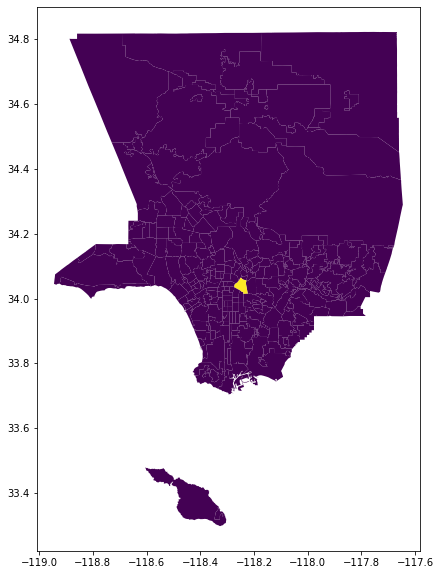

In [77]:
graph_region(la_neighbors, 'Downtown')

In [ ]:
cleaned_region_map = {
    'Downtown': ['City', 'Melrose', 'Temple', 'Pico']
}
wrong_map = ['Santa Monica Mountains', 'Melrose', '']

In [75]:
from collections import defaultdict

la_to_covid_map = defaultdict(list)

for covid_c in missing_arr:
    data = find_la_region(covid_c)
    if data[0].shape[0] == 0:
        continue
    la_to_covid_map[data[0].iloc[0,0]].append({covid_c:(data[1], data[2])})
la_to_covid_map

defaultdict(list,
            {'Downtown': [{'City': (34.0536909, -118.2427666)},
              {'Melrose': (34.0536909, -118.2427666)},
              {'Santa Monica Mountains': (34.031132, -118.261507)},
              {'Temple': (34.0536909, -118.2427666)},
              {'Pico': (34.0406717, -118.2661915)},
              {'Wholesale District': (34.0365749, -118.2354342)},
              {'Brookside': (34.0536909, -118.2427666)},
              {'Central': (34.0536909, -118.2427666)},
              {'Little Tokyo': (34.04821679999999, -118.2411814)},
              {'Temple-Beaudry': (34.062884600000004, -118.2512529)}],
             'Silver Lake': [{'Silverlake': (34.092941, -118.2697155)}],
             'Vernon': [{'West Vernon': (34.007135, -118.22525)},
              {'Vernon Central': (34.007135, -118.22525)}],
             'Baldwin Hills/Crenshaw': [{'Baldwin Hills': (34.01098870000001,
                -118.3370709)}],
             'Century City': [{'Century Palms/Cove': (34.062844